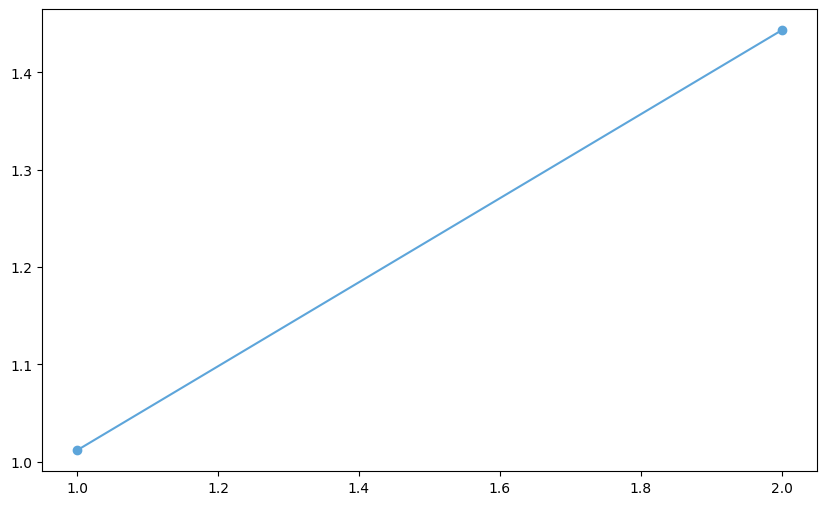

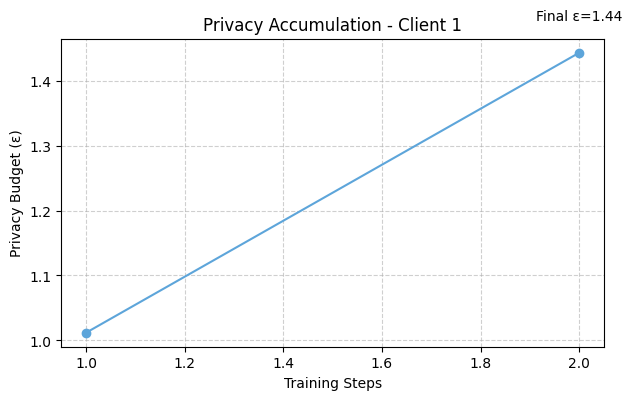

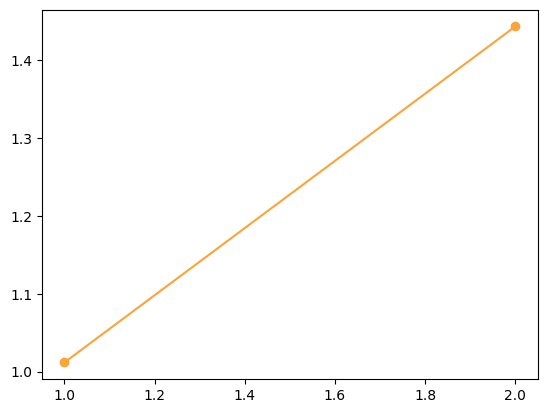

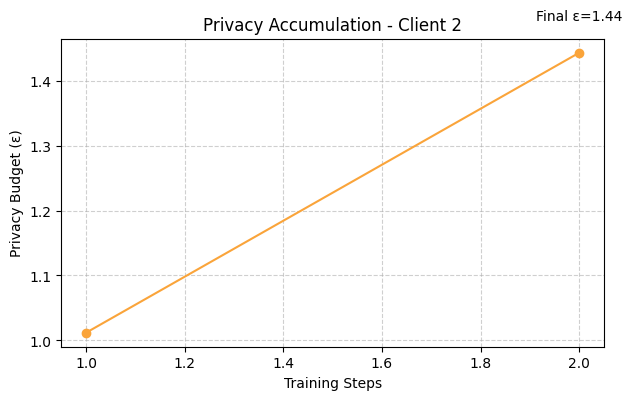

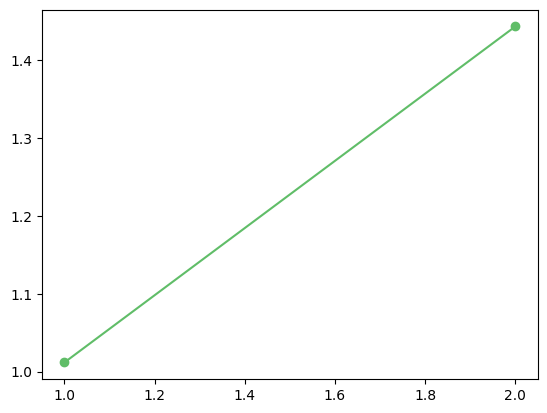

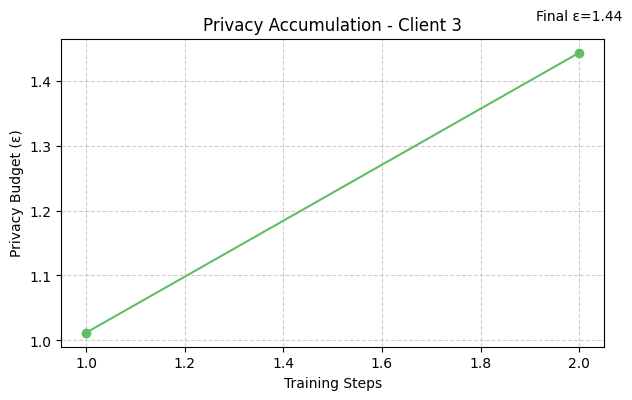

/var/folders/74/2vzj47vd1kv89xn8z39903w00000gn/T/ipykernel_2751/1206209536.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


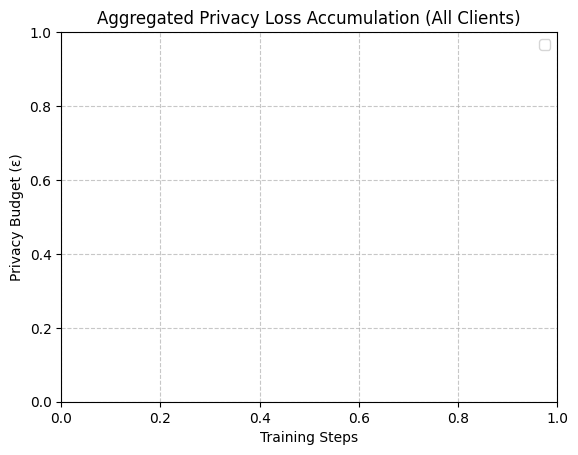

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# --- CONFIGURATION ---
# Path relative to the project root
RESULTS_DIR = "../../results/results-2026.01.14-federated-kcenter-rdp"
ORDERS = np.arange(1.1, 64, 0.1)  # Range of alphas for RDP-to-DP conversion

def compute_dp_epsilon(steps, sigma, delta, orders=ORDERS):
    """
    Computes the tightest (epsilon, delta)-DP guarantee for a Gaussian mechanism.
    """
    best_eps = float('inf')
    for alpha in orders:
        # RDP epsilon for Gaussian mechanism
        rdp_eps = (steps * alpha) / (2 * (sigma**2))
        # Convert to standard DP epsilon
        dp_eps = rdp_eps + np.log(1 / delta) / (alpha - 1)
        if dp_eps < best_eps:
            best_eps = dp_eps
    return best_eps

def load_and_plot():
    # 1. Load Data
    files = glob.glob(os.path.join(RESULTS_DIR, "client_*_dp_budget.json"))
    client_budgets = {}
    for f in files:
        client_name = os.path.basename(f).replace("_dp_budget.json", "")
        with open(f, 'r') as jf:
            client_budgets[client_name] = json.load(jf)
    
    if not client_budgets:
        print(f"No budget files found in {RESULTS_DIR}")
        return

    # 2. Aggregated Plot Setup
    plt.figure(figsize=(10, 6))
    colors = ['#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0']
    
    # 3. Process each client
    for i, (client_id, data) in enumerate(sorted(client_budgets.items())):
        steps_total = data.get('steps', 0)
        sigma = data.get('sigma', 0)
        delta = data.get('delta', 1e-5)
        
        steps_range = np.arange(1, steps_total + 1)
        eps_values = [compute_dp_epsilon(s, sigma, delta) for s in steps_range]
        
        # Plot Individual Clients in the Aggregated chart
        label = f"{client_id.replace('_', ' ').title()} (σ={sigma:.2f})"
        plt.plot(steps_range, eps_values, marker='o', linestyle='-', 
                 label=label, color=colors[i % len(colors)])
        
        # Also show Individual Plot
        plt.figure(figsize=(7, 4))
        plt.plot(steps_range, eps_values, marker='o', color=colors[i % len(colors)])
        plt.title(f"Privacy Accumulation - {client_id.replace('_', ' ').title()}")
        plt.xlabel("Training Steps")
        plt.ylabel("Privacy Budget (ε)")
        plt.grid(True, linestyle='--', alpha=0.6)
        if eps_values:
            plt.annotate(f'Final ε={eps_values[-1]:.2f}', 
                         xy=(steps_range[-1], eps_values[-1]), 
                         xytext=(steps_range[-1], eps_values[-1] + 0.05),
                         ha='center')
        plt.show()
        
        # Return focus to aggregated plot (figure index 1)
        plt.figure(1)

    # 4. Finalize Aggregated Plot
    plt.figure(1)
    plt.title("Aggregated Privacy Loss Accumulation (All Clients)")
    plt.xlabel("Training Steps")
    plt.ylabel("Privacy Budget (ε)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Run the function
if __name__ == "__main__":
    load_and_plot()
